# FWI on field data (CGG Broadseis)

by Oleg Ovcharenko

oleg.ovcharenko@kaust.edu.sa

KAUST, 2021

In [2]:
import os
import sys
#api._cmd('conda activate torch2')
print(f'Python: {sys.prefix}')
import copy
from glob import glob
# import glob
import numpy as np
import importlib
import multiprocessing
import segyio
from scipy import signal, ndimage
from natsort import natsorted
from skimage.transform import rescale, resize
from utils import shared as sd
from utils import loaders as ld
from utils import vis
from IPython.display import clear_output
# append path with actual source files to sys.path
sys.path.append(os.path.abspath('../codes_server'))
sys.path.append(os.path.abspath('./utils'))
from F_utils import *
from F_fwi import *
import pyapi_denise_pavel as api
api._cmd('source /home/plotnips/Madagascar/share/madagascar/etc/env.sh')
api._cmd('source ~/.bashrc')
# create_sbatch_file_for_fwi_folder('./for_pasha/out_for_pasha/fwi_full_spectrum_vanilla')
# results_path='./out_for_pasha/fwi_full_spectrum'
# os.system(f"rm -r {results_path}")
print(filter_seismic_data)
d=api.Denise('/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master',verbose=1)
print(d.get_shots_from_datadir)
print(d.get_shots_from_directory)
print(sys.path)

Python: /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env
<function filter_seismic_data at 0x7f8a27404268>
Init Python 3 API for Denise-Black-Edition.
Check binary in /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/bin/denise
Parse /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/par/DENISE_marm_OBC.inp
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./outputs/
<bound method Denise.get_shots_from_datadir of DENISE-Black-Edition:
	/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master
Save folder:
	./outputs/
Run .help() for more details>
<bound method Denise.get_shots_from_directory of DENISE-Black-Edition:
	/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master
Save folder:
	./outputs/
Run .help() for more details>
['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-

In [3]:
calculate_water_taper

<function F_utils.calculate_water_taper(generated_model, min_water_velocity=1490.001)>

In [4]:
# # This is to prevent error "this loop already runnign when doing magical %run <<notebook name>>"
import nest_asyncio
nest_asyncio.apply()

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 300,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [6]:
root_fwi = './out_for_pasha/'

# Init Denise API

In [7]:
denise_root = '../'
d = api.Denise(denise_root, verbose=1)

Init Python 3 API for Denise-Black-Edition.
Check binary in ../bin/denise
Parse ../par/DENISE_marm_OBC.inp
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./outputs/


## Work directory
Where to output everything

In [8]:
d.save_folder = root_fwi
d.set_paths()

Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./out_for_pasha/


# Get acquitision details

In [9]:
shot_id_min = 60
n_selected_shots = 2   #   80
njump_src = 8
shot_id_max = shot_id_min + (n_selected_shots-1) * njump_src
print(shot_id_max)

68


2/2
Before prep:	(2, 648, 3526)
Data cube:	(2, 324, 3000)
Extended cube:	(2, 324, 3100)
[2, 324, 3050] (2, 324, 3000)
[2, 324, 3150] (2, 324, 3100)
25.0
Assume even average spacing between sources
 125.0 m ~ 5 grid nodes
First source:	1125.0 m
Last source:	1250.0 m
125.0
name:	
x	(2,):	min: 1125.0	max: 1250.0
y	(2,):	min: 50.0	max: 50.0
wavelets:	None
z	(2,):	min: 0.0	max: 0.0
nshot:	2
td	(2,):	min: 0.0	max: 0.0
fc	(2,):	min: 8.0	max: 8.0
amp	(2,):	min: 1.0	max: 1.0
angle	(2,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(2,):	min: 1.0	max: 1.0
drec:	25.0 m
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]
(152, 600)
(152, 600)
(152, 500)
12500.0


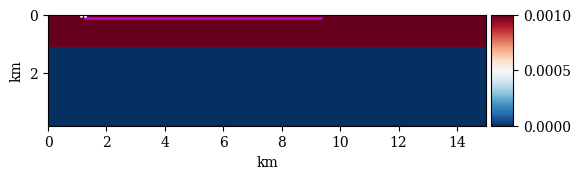

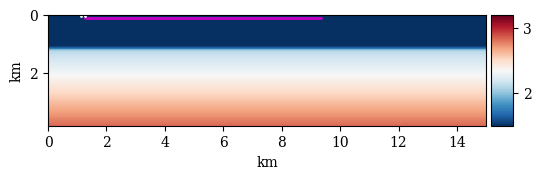

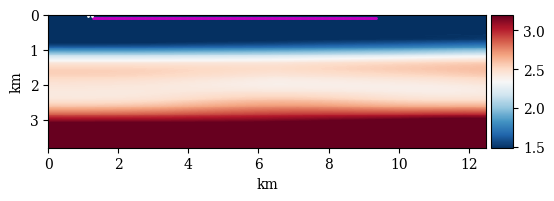

In [10]:
%run ./fwi_shared_check.ipynb
wavefield_amp_ratio = 77.08343437940496
wls = bpw[:, ::2]
src.wavelets = wavefield_amp_ratio * wls[:, :limit_nt]

In [11]:
print('Field data spacing between sources {:.2f} m'.format(np.mean(src_.x[1:] - src_.x[:-1])))

Field data spacing between sources 130.71 m


In [12]:
vp_baseline = vp.copy()
print(vp.shape)

marm_path = os.path.join(root_fwi, 'start/')
os.makedirs(marm_path, exist_ok=True)
print(marm_path)
if not 'marmousi_II_marine.vp' in os.listdir(marm_path):
    # Download Marmousi II model
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.rho -P {marm_path}')

    # Download initial model for FWI
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.rho -P {marm_path}')
   
def get_vp_vs_rho(vp):
    vp = extend(vp, 15, 0)

    print(f'Reshape {vp.shape} into {wb_taper.shape}...')

    vp = resize(vp, wb_taper.shape, anti_aliasing=True)
    vp = np.where(vp <= 1500.0, 1490.0, vp)
    vp = extend(vp, 0, 264 + 10 * 8)

    # shear velocity, [m/s]
    vs = vp.copy() / (3 ** 0.5)
    vs = np.where(vp < 1.01 * np.min(vp), 0, vs)

    # density, [kg/m3] 
    rho = 1e3*0.3 * vp.copy()**0.25
    rho = np.where(vp < 1.01 * np.min(vp), 1000, rho)
    return vp, vs, rho

(152, 600)
./out_for_pasha/start/


In [13]:
vp_long = extend(model.vp, 0, 264 + 10 * 8)
vp_cgg_tomo=vp_cgg
vp_cgg_tomo_long = extend(vp_cgg_tomo, 0, 364 + 10 * 8)
wb_taper2=extend(wb_taper, 0,264 + 10 * 8)
wb_taper3=calculate_water_taper(np.flipud(vp_cgg_tomo_long),min_water_velocity=1.01 * vp_cgg_tomo_long.min())
wb_taper3=np.flipud(wb_taper3)
vp_cgg_tomo_long2=np.where(wb_taper2,1490.0,vp_cgg_tomo_long)
lin_vp_long=vp_long.copy()

In [14]:
# print(wlog)
print(log_location)

10500.0


(152, 600)
(152, 600)
(152, 944)
(152, 944)
(152, 500)
(152, 944)


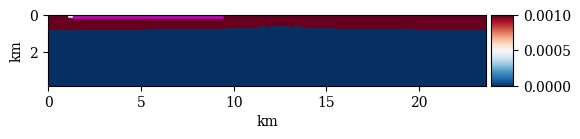

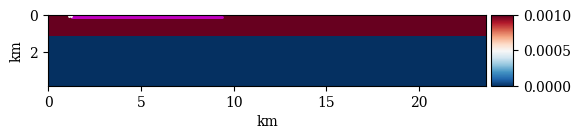

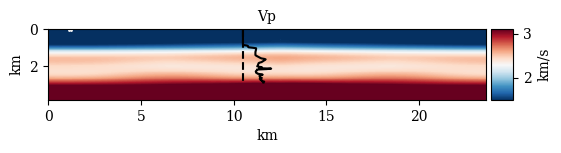

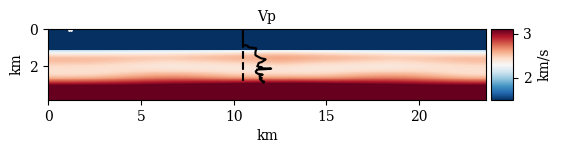

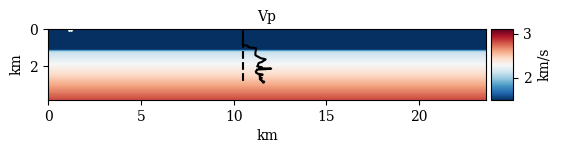

In [15]:
print(model.vp.shape)
print(wb_taper.shape)
print(wb_taper2.shape)
print(vp_long.shape)
print(vp_cgg_tomo.shape)
print(vp_cgg_tomo_long.shape)
# vis.plot_acquisition(vp_baseline,dx,src,rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
# vis.plot_acquisition(model.vp,dx,src,rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
# vis.plot_acquisition(vp_cgg_tomo, dx, src, rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
vis.plot_acquisition(wb_taper3,dx,src,rec)
vis.plot_acquisition(wb_taper2,dx,src,rec)
# vis.plot_acquisition(vp_cgg_tomo_long, dx, src, rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
# vis.plot_acquisition(vp_cgg_tomo_long2, dx, src, rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
# vis.plot_acquisition(lin_vp_long, dx, src, rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})

vis.plot_log_model(vp_cgg_tomo_long, dx, _src=src,title='Vp',**{'vmax': 3.1, 'vmin': 1.5},log=wlog,log_location=log_location)
vis.plot_log_model(vp_cgg_tomo_long2, dx,_src=src,title='Vp',**{'vmax': 3.1, 'vmin': 1.5},log=wlog,log_location=log_location)
vis.plot_log_model(lin_vp_long, dx, _src=src,title='Vp',**{     'vmax': 3.1, 'vmin': 1.5},log=wlog,log_location=log_location)


cgg_tomo_long1=[vp_cgg_tomo_long,wb_taper3]
cgg_tomo_long2=[vp_cgg_tomo_long2,wb_taper2]
cgg_lin_vp_long=[lin_vp_long,wb_taper2]
log_dict = {'data':wlog, 'loc': log_loc}
acq_data = {'src':src,'rec':rec,'wavelet':bpw,'src_x0':src_x0,'rec_x0':rec_x0,'dsrc':dsrc,'drec':drec,'DT':dDT,'log_dict':log_dict,'cgg_tomo_long1':cgg_tomo_long1,'cgg_tomo_long2':cgg_tomo_long2,'cgg_lin_vp_long':cgg_lin_vp_long}

In [16]:
# print(src)
print(os.getcwd())
print(acq_data['src'])
with open(os.path.join('acq_data_parameters_cgg.pkl'), 'wb+') as output:
    pickle.dump(acq_data,output,protocol=4)
with open(os.path.join('acq_data_parameters_cgg.pkl'),'rb') as input:
    acq_data2=pickle.load(input)
print(acq_data2['src'])

/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
name:	
x	(2,):	min: 1125.0	max: 1250.0
y	(2,):	min: 50.0	max: 50.0
wavelets	(2, 3000):	min: -400.8610078720592	max: 484.6122728113698
z	(2,):	min: 0.0	max: 0.0
nshot:	2
td	(2,):	min: 0.0	max: 0.0
fc	(2,):	min: 8.0	max: 8.0
amp	(2,):	min: 1.0	max: 1.0
angle	(2,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(2,):	min: 1.0	max: 1.0
name:	
x	(2,):	min: 1125.0	max: 1250.0
y	(2,):	min: 50.0	max: 50.0
wavelets	(2, 3000):	min: -400.8610078720592	max: 484.6122728113698
z	(2,):	min: 0.0	max: 0.0
nshot:	2
td	(2,):	min: 0.0	max: 0.0
fc	(2,):	min: 8.0	max: 8.0
amp	(2,):	min: 1.0	max: 1.0
angle	(2,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(2,):	min: 1.0	max: 1.0


## Acquisition design

In [17]:
# Wavelet scaler to match field and synthetic
print(1.01 * vp_cgg_tomo_long.min())
print(1.0 * vp_cgg_tomo_long.min())

1504.9
1490.0


(152, 600)
(152, 944)


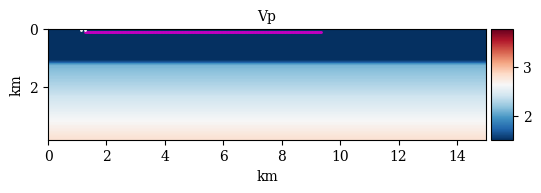

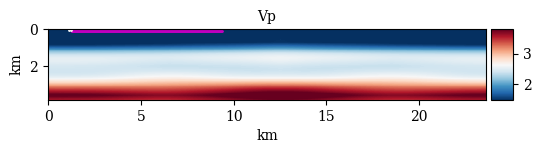

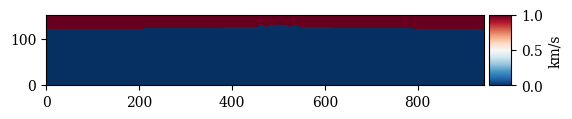

In [18]:
# Set custom wavelet
# wls = bpw[:, ::2]
# src.wavelets = wavefield_amp_ratio * wls[:, :limit_nt]
wb_taper = np.where(vp_cgg_tomo_long < 1.01 * vp_cgg_tomo_long.min(), 1, 0)
# vis.plot_model(wb_taper3-wb_taper)
wb_taper=wb_taper3
vis.plot_acquisition(vp,dx,src,rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
vis.plot_acquisition(vp_cgg_tomo_long, dx, src, rec, title='Vp',**{'vmax': 3.8, 'vmin': 1.5})
vis.plot_model(wb_taper3)
# print(vp_cgg_tomo_long)
print(vp.shape)
print(vp_cgg_tomo_long.shape)

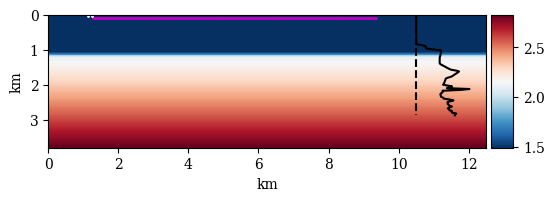

In [19]:
# log = model.vp[:, log_idx]
log = model.vp[-len(wlog):, log_idx]
# model_log = copy.deepcopy(model)
log_dict = {'data':wlog, 'loc': log_loc}
vis.plot_acquisition(vp[:, :500], dx, src, rec, log=log_dict)
# vis.savefig('vinit.png')

Create new initial (orange line). This is to see whether knowledge about exact waterbottom will improve results

(152, 944)
Well-log from 10500 maps into ix: 420


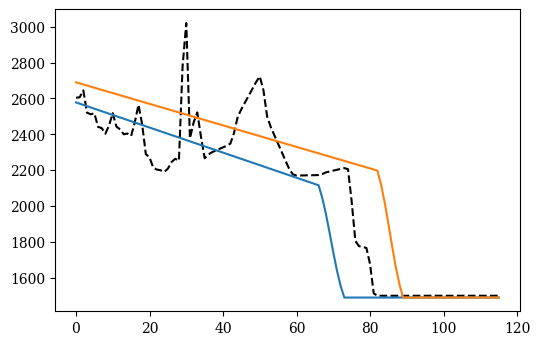

In [20]:
new_vp = np.zeros_like(model.vp)
vps=[]
for i in range(wb_taper.shape[-1]):
    wb = wb_taper.shape[0] - np.argmax(wb_taper[:,i]) + 2
    fun = vmin * np.ones_like(new_vp[:, 0:1])
    fun[wb:, :] = 690 + fun[wb:, :] + 6 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    fun = fun[::-1, :]
    vps.append(fun)
new_vp = np.concatenate(vps, -1)
new_vp = gaussian_filter(new_vp.copy(), **sigma_truncate)

print(new_vp.shape)
print(f'Well-log from {log_loc} maps into ix: {log_idx}')
plt.figure(); plt.plot(wlog, 'k--'); plt.plot(log[-len(wlog):]); plt.plot(new_vp[-len(wlog):, log_idx])

Set new model as initial

In [21]:
vp = vp_cgg_tomo_long2.copy()
# vp = new_vp.copy()
vs = vp.copy() / (3 ** 0.5)
rho = 1e3*0.3 * vp.copy()**0.25

vp = np.where(wb_taper, np.min(vp), vp)
vs = np.where(wb_taper, 0, vs)
rho = np.where(wb_taper, 1000, rho)

# log = vplog.copy()
model = api.Model(vp, vs, rho, dx)
print(src, end='\n\n------------\n')
print(rec)

name:	
x	(2,):	min: 1125.0	max: 1250.0
y	(2,):	min: 50.0	max: 50.0
wavelets	(2, 3000):	min: -400.8610078720592	max: 484.6122728113698
z	(2,):	min: 0.0	max: 0.0
nshot:	2
td	(2,):	min: 0.0	max: 0.0
fc	(2,):	min: 8.0	max: 8.0
amp	(2,):	min: 1.0	max: 1.0
angle	(2,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(2,):	min: 1.0	max: 1.0

------------
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]


In [22]:
print(src)
# print(rec[0:1])
# src=src[::40]
# rec=rec[::40]
# src

name:	
x	(2,):	min: 1125.0	max: 1250.0
y	(2,):	min: 50.0	max: 50.0
wavelets	(2, 3000):	min: -400.8610078720592	max: 484.6122728113698
z	(2,):	min: 0.0	max: 0.0
nshot:	2
td	(2,):	min: 0.0	max: 0.0
fc	(2,):	min: 8.0	max: 8.0
amp	(2,):	min: 1.0	max: 1.0
angle	(2,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(2,):	min: 1.0	max: 1.0


## Generate true waveforms

Set some runtime parameters which are different from defaults. Check defaults by runnning `help()`

In [23]:
# Elastic modeling
d.verbose = 1
d.PHYSICS = 1
d.DT = dDT
d.NT = data_p.shape[-1]
d.TIME = dDT * d.NT
#
d.FC_SPIKE_2 = 10
# DSCRC=5000;     
# dsrc=DSCRC
d.REC_INCR_X = dsrc
d.N_STREAMER = len(rec)
d.TESTSHOT_START = 1
d.TESTSHOT_END = len(src)
d.TESTSHOT_INCR = 10
d.QUELLTYPB = 4
d.QUELLART = 3  
d.WRITE_STF = 0
d.SEISMO = 2

# d.TESTSHOT_START = np.round(0.1 * len(src))
# d.TESTSHOT_END = np.round(0.9 * len(src))
# d.TESTSHOT_INCR = 5
print(d.DT, d.NT)

0.002 3000


### Run forward modeling

In [24]:
d.NPROCX = 8
d.NPROCY = 2
par_forward = {'run_command': 'mpirun -np 30', 'disable': False}
print(d.DATA_DIR)

./out_for_pasha/su/seis


In [25]:
d.forward(model, src, rec, **par_forward)
# d.save_folder = root_fwi

Init model:
	152 x 944, dx = 25.0 m
Check max source frequency:
	min Vs: 860.2519010925424 m/s
	min Vp: 1490.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 9.32522386008176 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 944 % 8 = 0
	in Y-direction, NY % NPROCY, 152 % 2 = 0
Write ./out_for_pasha/start/model.vp
Write ./out_for_pasha/start/model.vs
Write ./out_for_pasha/start/model.rho
Enable streamer mode!
	source 1: ./out_for_pasha/receiver/receivers_shot_1
	source 2: ./out_for_pasha/receiver/receivers_shot_2
Write wavelets, one for every shot.
	wavelet 1: ./out_for_pasha/wavelet/wavelet_shot_1.dat
	wavelet 2: ./out_for_pasha/wavelet/wavelet_shot_2.dat
Start simulation for 2 sources. NT: 3000, DT: 0.002...wait


Done. 0.47011256217956543 sec.

Check results in ./out_for_pasha/su/


In [52]:
d.verbose = 0    # don't show redundant print outs
if d.DT is None:
    d.DT = 0.002
print(d.DATA_DIR)
shots,fnames = d.get_shots(keys=['_p.'],return_filenames=True)
# d=api.Denise('/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master',verbose=0)
# path2='/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/out_for_pasha/su'
# shots2,filenames2=d.get_shots_from_directory(path2,return_filenames=True)

./out_for_pasha/su/seis


In [35]:
print(len(shots)-1)
np.linspace(0, len(shots)-1, 2)
print(len(data_p))

1
2


Read 2 shots (324, 3000) into list
0
./out_for_pasha/su/seis_p.su.shot1
1
./out_for_pasha/su/seis_p.su.shot2


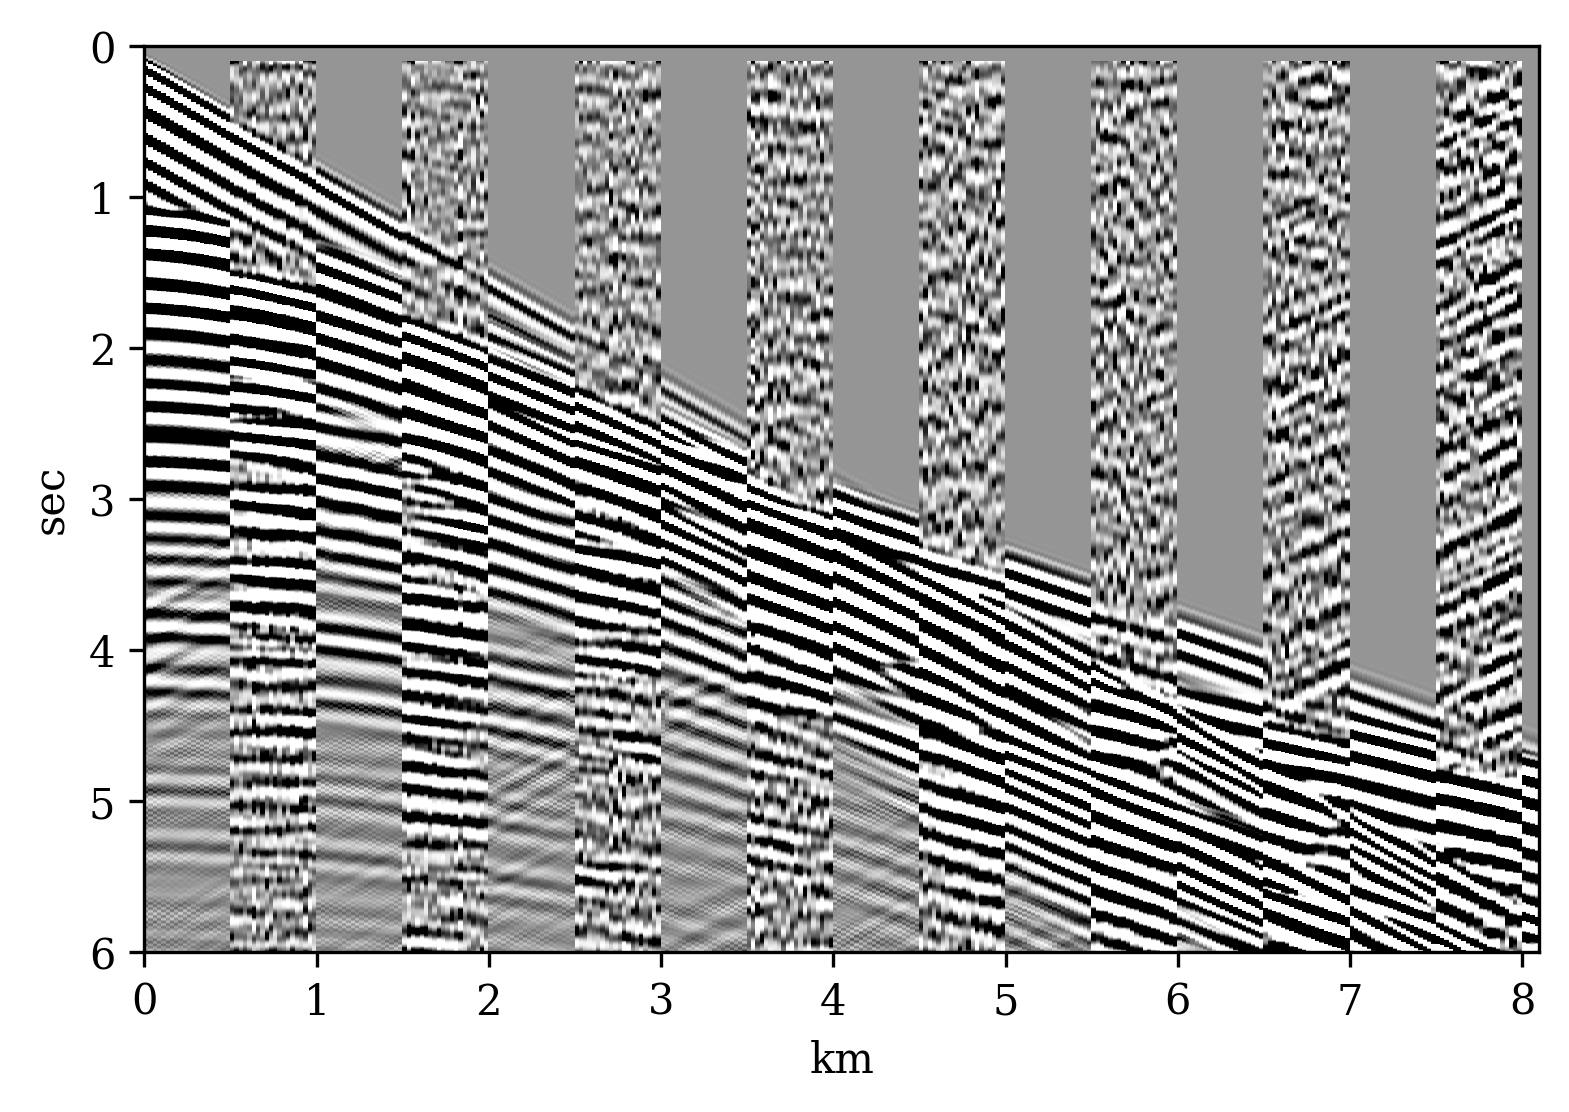

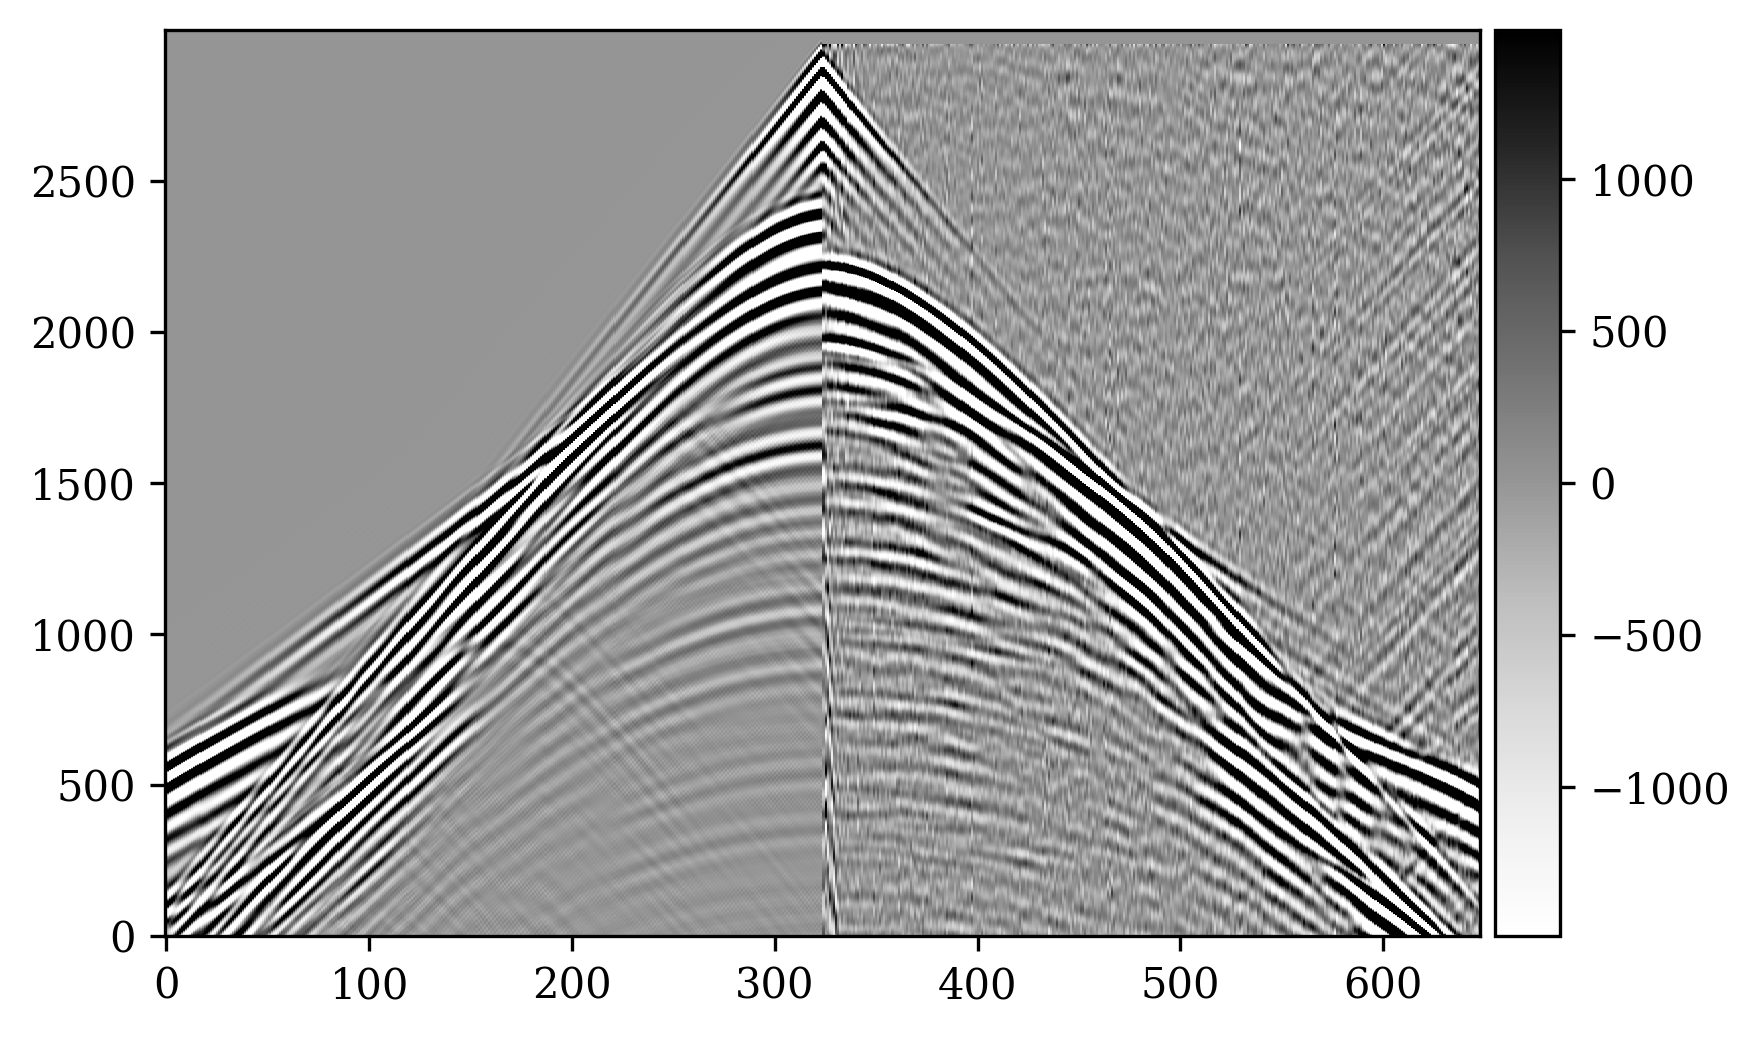

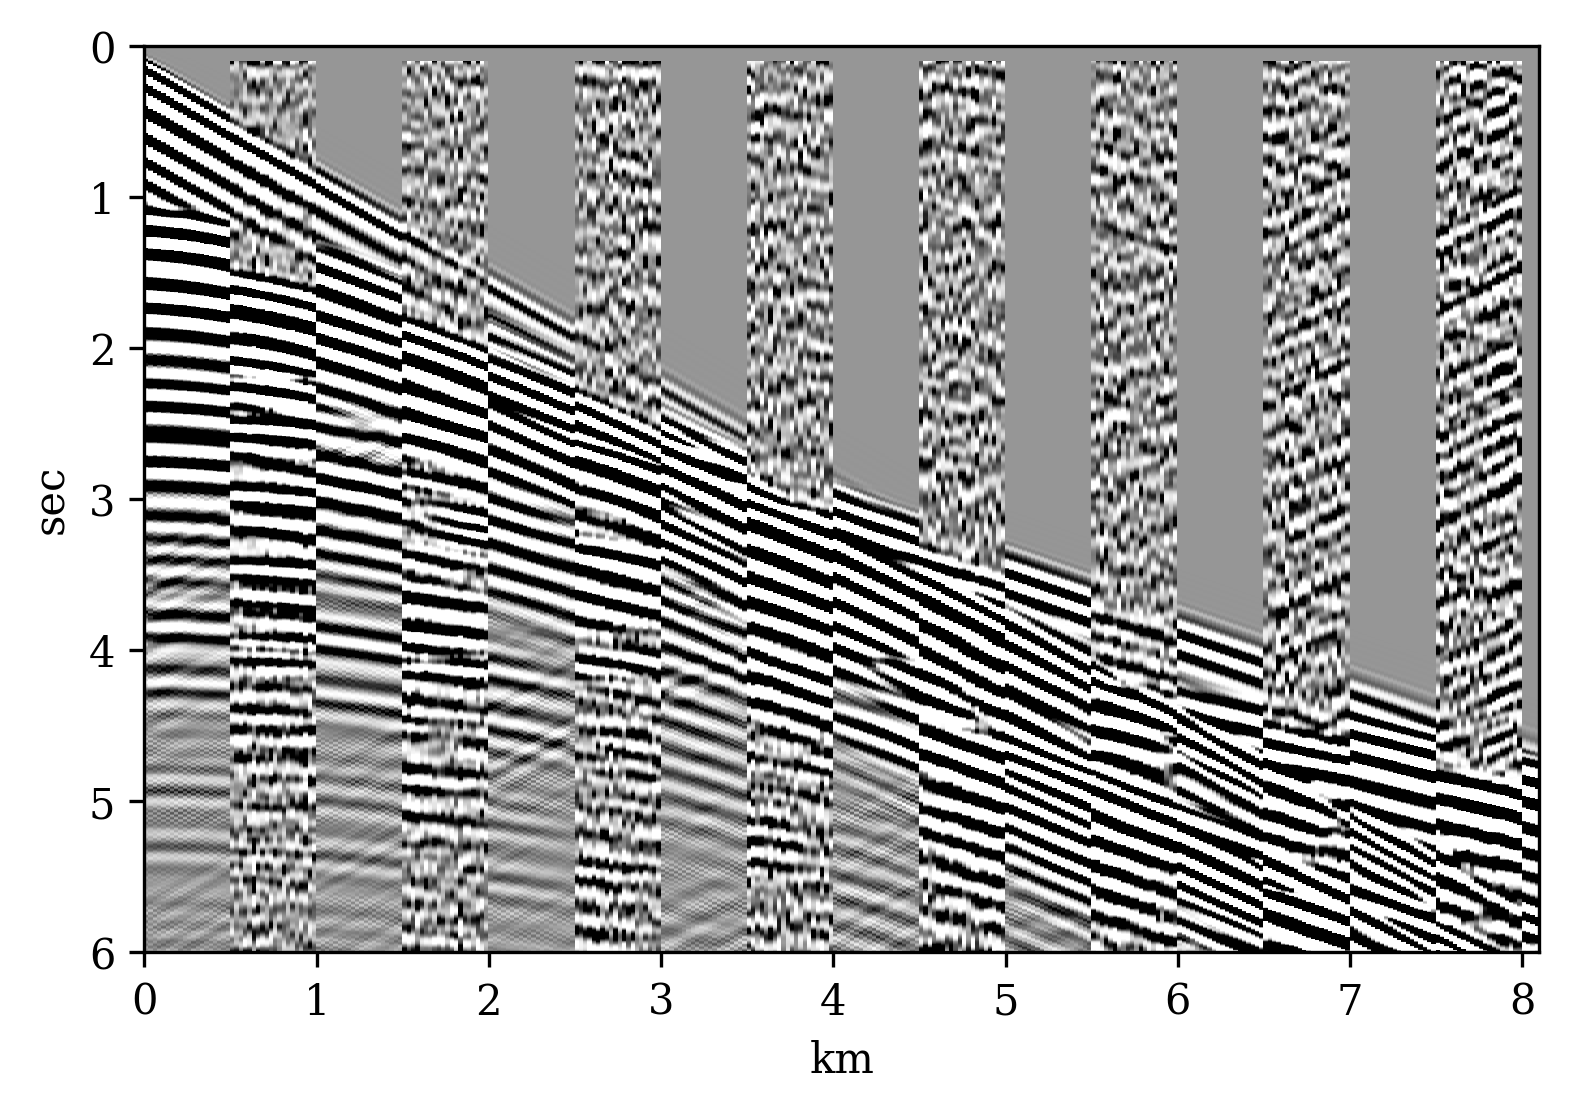

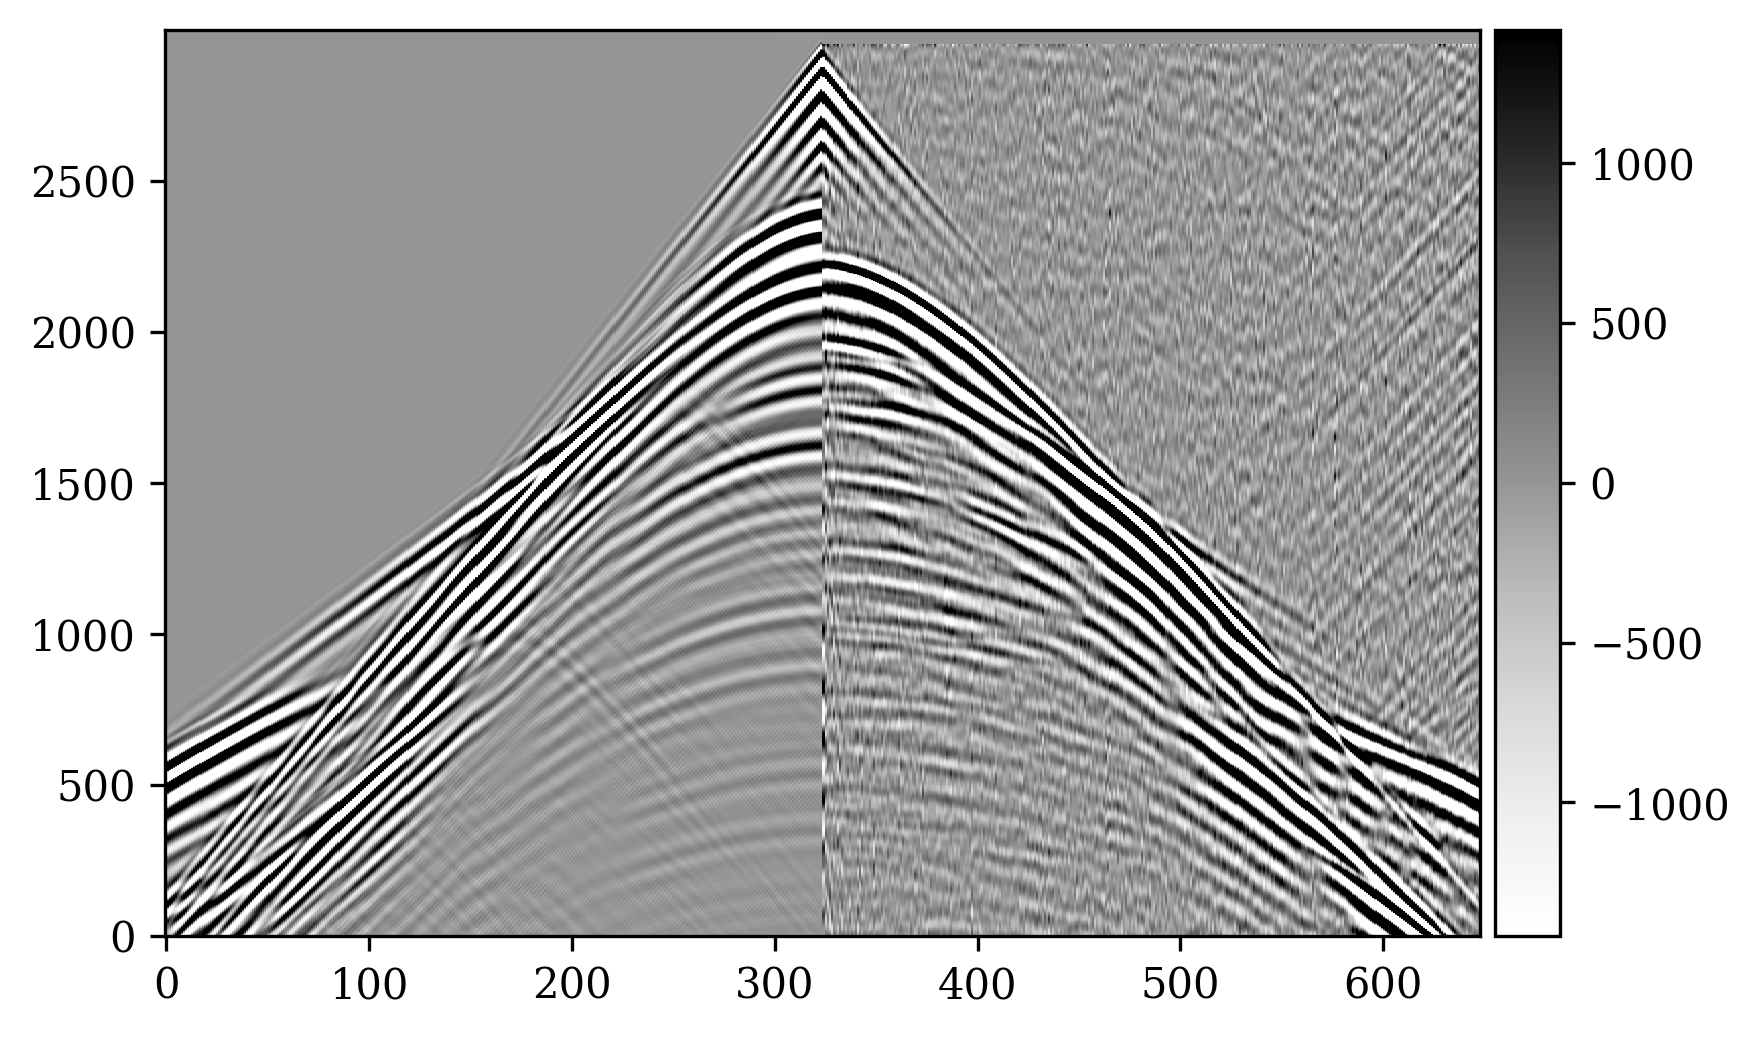

In [53]:
mpl.rcParams['figure.dpi']= 300
par_shot = {'vmin': -0.05, 'vmax': 0.05}
if shots:
    print(f'Read {len(shots)} shots {shots[0].shape} into list')
    # for i in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 5)]:
    for i in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 2)]:
        print(i)
        try:
            print(fnames[i])
            shot_s = shots[i]
            shot_f = data_p[i, :, ::d.NDT]
            vis.plot_compare_stripes(shot_s, shot_f, pclip=0.0125, colorbar=False, dt=d.DT, dx=dx)
            vis.plot_shot(np.concatenate([np.flip(shot_s, 0), shot_f],axis=0), pclip=0.0525)
            # vis.plot_shot(np.concatenate([np.flip(shot_s, 0), shot_f],axis=0), pclip=0.0125,folder_path=os.path.join(path,'pictures'),file_path='shot_side_by_side_comparison_withinitmodel_'+str(ishot)+'.png')
        except:
            print(f'Failed to fetch data for i={i}')

In [29]:
# wavefield_amp_ratio
print(np.max(np.abs(shot_f)) / np.max(np.abs(shot_s)) )

1.0165221136078069


# Compare syn and field

(2, 324, 3000)
2
Total sources: 2
Syn wavelets:	(2, 500)	-19284.29	26554.20
Field wavelets:	(2, 500)	-14600.08	23269.30
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


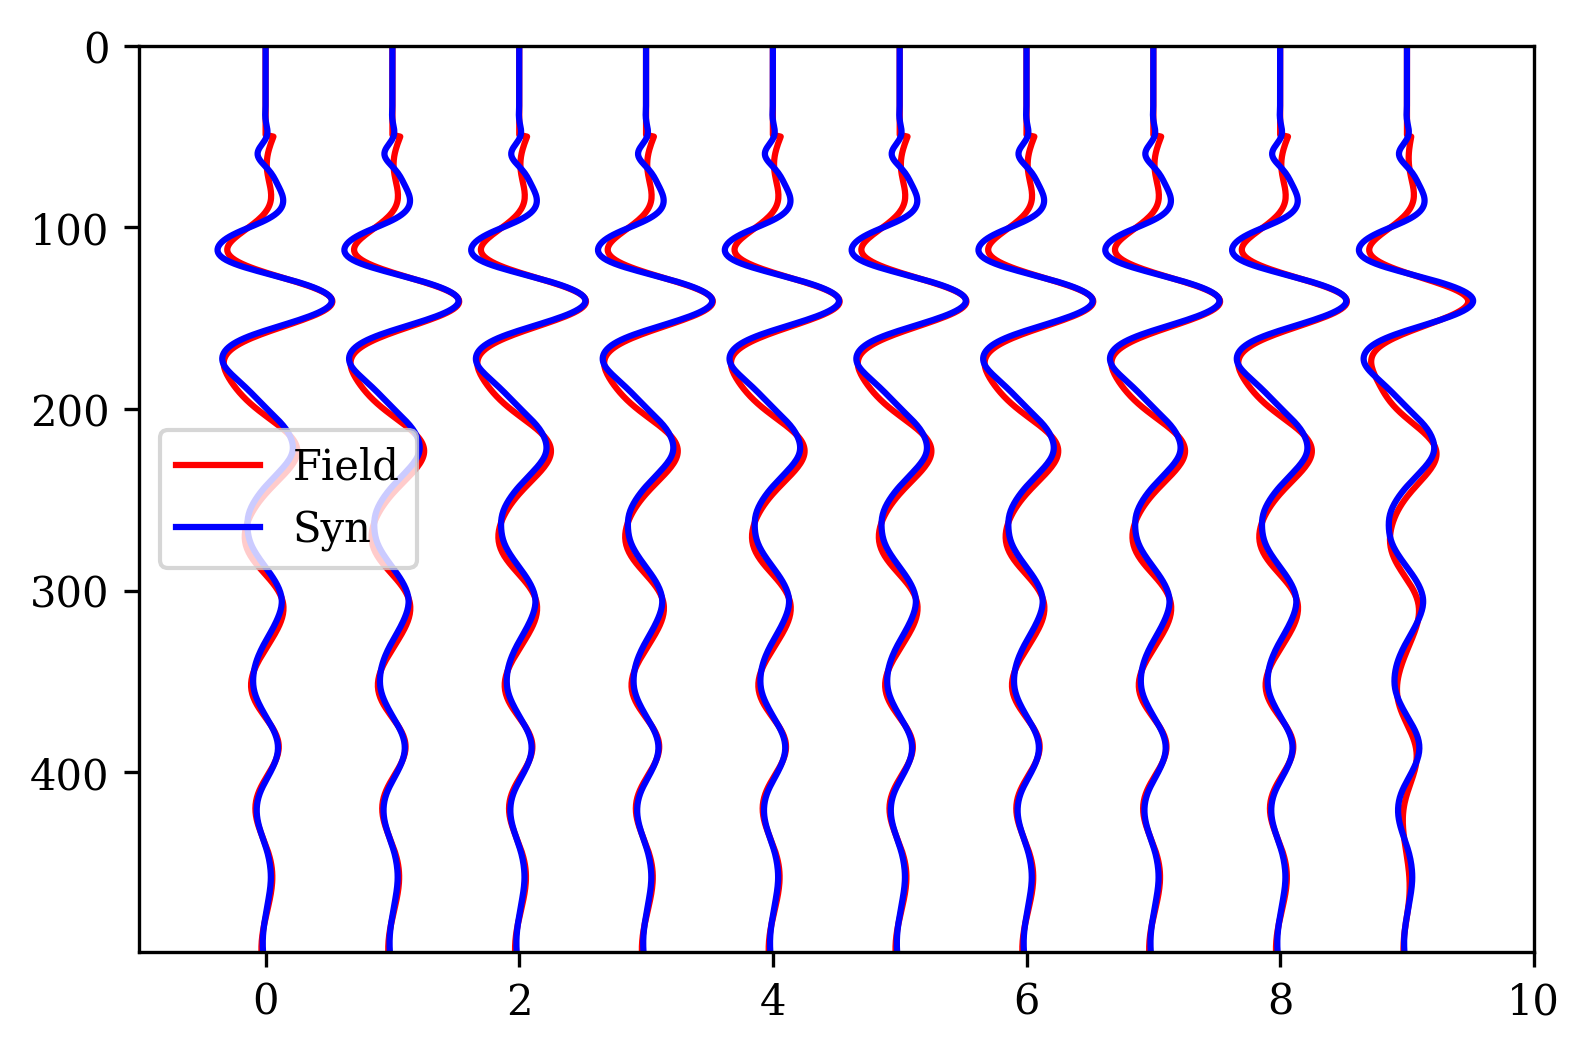

In [30]:
wavelets_s = []
wavelets_f = []
print(data_p.shape)
print(len(shots))
for i, shot in enumerate(shots):
    no, nt = 1, 500
    wavelets_s.append(shot[:no, :nt].copy())
    wavelets_f.append(data_p[i, :no, :nt:d.NDT].copy())
print(f'Total sources: {len(wavelets_f)}')
wavelets_s = np.concatenate(wavelets_s, 0)
wavelets_f = np.concatenate(wavelets_f, 0)

# !!! DO THIS IN FIELD DATA APPLICATION !!!
# THIS MAKES SYNTHETIC AND FIELD COMPARABLE
# OTHERWISE THERE IS INSANE AMPLITUDE MISMATCH
# wavelets_f /= np.max(wavelets_f)
# wavelets_f *= wavelets_s.max()

print('Syn wavelets:\t{}\t{:.2f}\t{:.2f}'.format(wavelets_s.shape, wavelets_s.min(), wavelets_s.max()))
print('Field wavelets:\t{}\t{:.2f}\t{:.2f}'.format(wavelets_f.shape, wavelets_f.min(), wavelets_f.max()))

vis.plot_wiggles([wavelets_f, wavelets_s], n=10, colors=['r', 'b'], legend=['Field', 'Syn'])

# REPLACE FIELD DATA BY MARM DATA